In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

A graph of 3 nodes:
0:[1]
1:[0]
2:[]

Nodes: [0, 1, 2]
Edges: [(0, 1)]


/Users/audreyrussell/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


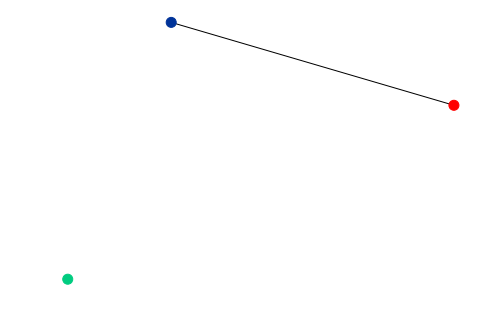

In [2]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.val = {}
        
    def add_node(self, node, val= None):
        if node not in self.gdict:
            self.gdict[node] = []
        self.val[node] = val
        
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
       
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return 
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
        
    def get_nodes(self):
        """list of nodes"""
        return list(self.gdict.keys()) 
    
    def get_edges(self):
        """list of edges"""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
    
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1,0,0)
        BLUE = (0,0.2,0.6)
        GREEN = (0, 0.8, 0.5)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.val[nodes[i]] is not None:
                if self.val[nodes[i]][0] == 'healthy':
                    colors.append(BLUE)
                elif self.val[nodes[i]][0] == 'infected':
                    colors.append(RED)
                else:
                    colors.append(GREEN)
            else:
                colors.append(BLUE)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.delete_edge(0,2)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.val[0] = ['infected', None]
g.val[2] = ['immune', None]
g.plot()       

In [3]:
def degrees(g):
    """histogram!"""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    
    plt.plot(hist,'.-');
    plt.xlabel('degrees')
    plt.ylabel('frequency')
    
    return hist

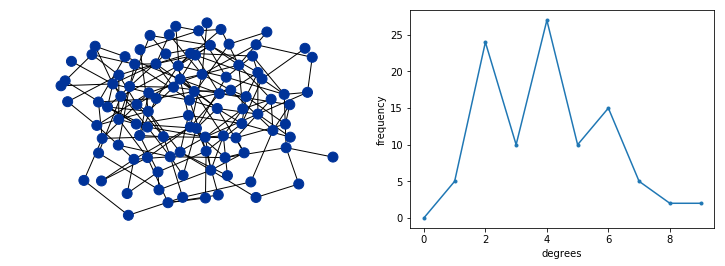

In [4]:
def random_network(n_nodes=7):
    n_edges = 2 * n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g

g = random_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

array([0., 0., 6., 8., 0., 2., 2., 1., 0., 1.])

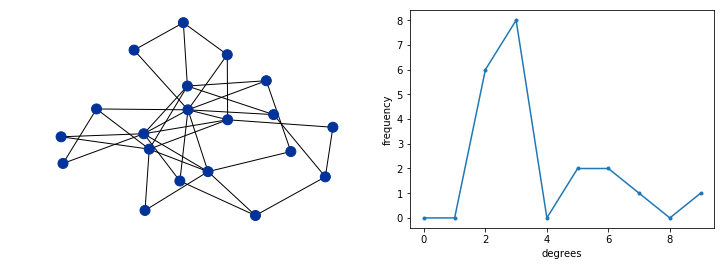

In [5]:
def barabasi(n_nodes = 9):
    """n edges = 2 * n nodes"""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    
    for i in range(n_nodes):
        if i == 0:
            g.add_node(0)
        elif i == 1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else:
            connections = np.random.choice(nodes[:i], size = 2, replace = False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i, "nodes:", nodes, "degrees:", degrees)
    return g

g = barabasi(20)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g)

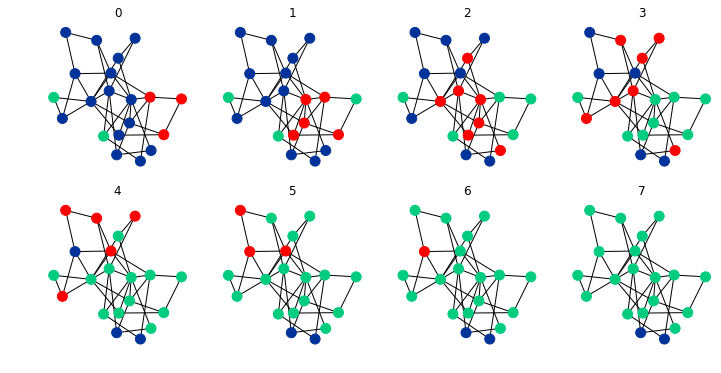

In [6]:
def pandemic(g, prob = 0.5, nsteps = 30, period = 1, vax_rate = 0, reinitialize = True):
    nodes = g.get_nodes()
    if reinitialize:
        for node in nodes:
            if np.random.uniform() < vax_rate:
                g.val[node] = ['immune', 0]
            else:
                g.val[node] = ['healthy', 0]  
        patient_zero = np.random.randint(low = 0, high = len(nodes))
        g.val[patient_zero] = ['infected', 0]           

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = [] 
        is_active = False
        for node in nodes:
            if g.val[node][0] == 'infected':
                is_active = True
                if g.val[node][1] == period:
                    g.val[node][0] = 'immune'
                else:
                    g.val[node][1] += 1
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.val[neighbor][0]== 'healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.val[node] = ['infected',0]
        history[t] = len(newly_infected)
    return history

g = barabasi(20)
plt.figure(figsize = (12,6))
for i in range(8):
    if i == 0:
        pandemic(g, prob = 0.5, nsteps = 1, period = 0.1, vax_rate = 0.1)
    else:
         pandemic(g, prob = 0.5, nsteps = 1, period = 1, reinitialize = False)
    plt.subplot(2,4,i+1)
    g.plot()
    plt.title(i)

# model inventory

inputs(parameters)
re: network: network type (barabasi-albert can be compared/contrasted with different model or altered in itself), network size, number of edges (could be made mroe flexible)

re: disease: probability of disease propagation (and the logic thereof) period of infectiousness, and vaccination rate
outputs (things to measure: share of nodes infected, peak height of new cases, length of curve/time points of peak and fall

In [7]:
N_STEPS = 20
N_NODES = 100

# PROB = 0.2
N_PROB_STEPS = 10 #how many values prob uses
INFECT_PERIOD = 10
N_TRIALS = 1 #for each combination of parameters

history = np.zeros(shape = (N_STEPS, N_TRIALS*N_PROB_STEPS))
total_infected = np.zeros(shape = (N_TRIALS, N_PROB_STEPS))
prob = np.zeros(N_PROB_STEPS)
for iprob in range(N_PROB_STEPS):
    prob[iprob] = (iprob + 1) / N_PROB_STEPS
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        history[:,itrial + iprob * N_TRIALS] = pandemic(g, prob = prob[iprob],
                                                        nsteps = N_STEPS, period = INFECT_PERIOD)
        count_infected = 0
        for node, val in g.val.items():
            if val[0] == 'immune':
                count_infected += 1
        total_infected[itrial, iprob] = count_infected

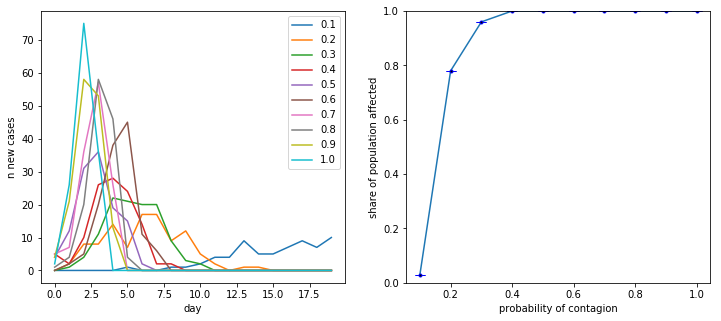

In [15]:
plt.figure(figsize = (12,5))
plt.subplot(121)
for iprob in range(N_PROB_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS * iprob) : (N_TRIALS * (iprob + 1))], axis = 1), label = prob[iprob]);
plt.xlabel("day");
plt.ylabel("n new cases");
plt.legend(loc = 'upper right')

plt.subplot(122)
plt.plot(prob, np.average(total_infected, axis = 0)/N_NODES, '-', markerfacecolor = 'blue')
plt.errorbar(prob, np.average(total_infected, axis = 0)/ N_NODES, 
             yerr = np.std(total_infected, axis = 0) / N_NODES, fmt = '.b', capsize = 5,
             ecolor = 'blue', markerfacecolor = 'k')
plt.xlabel('probability of contagion')
plt.ylabel('share of population affected')
plt.ylim(0,1);

hw question: make a different measurement–add variance to probability and see how it affects the population

<Figure size 864x432 with 0 Axes>

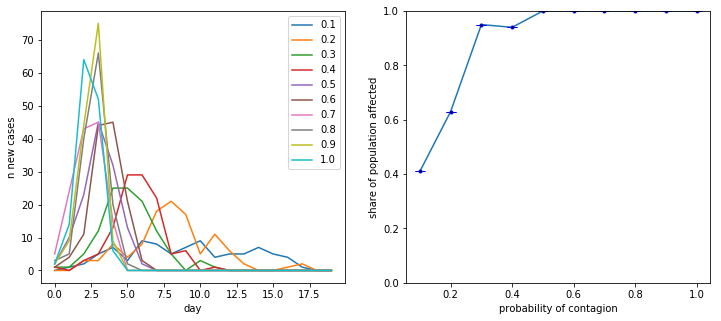

In [17]:
def pandemic(g, prob = np.random.randint(low = 0, high = 2), nsteps = 30, period = 1, vax_rate = 0, reinitialize = True):
    nodes = g.get_nodes()
    if reinitialize:
        for node in nodes:
            if np.random.uniform() < vax_rate:
                g.val[node] = ['immune', 0]
            else:
                g.val[node] = ['healthy', 0]  
        patient_zero = np.random.randint(low = 0, high = len(nodes))
        g.val[patient_zero] = ['infected', 0]           

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = [] 
        is_active = False
        for node in nodes:
            if g.val[node][0] == 'infected':
                is_active = True
                if g.val[node][1] == period:
                    g.val[node][0] = 'immune'
                else:
                    g.val[node][1] += 1
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.val[neighbor][0]== 'healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.val[node] = ['infected',0]
        history[t] = len(newly_infected)
    return history

g = barabasi(20)
plt.figure(figsize = (12,6))
for i in range(8):
    if i == 0:
        pandemic(g, prob = np.random.randint(low = 0, high = 2), nsteps = 1, period = 0.1, vax_rate = 0.1)
    else:
         pandemic(g, prob = np.random.randint(low = 0, high = 2), nsteps = 1, period = 1, reinitialize = False)
    #plt.subplot(2,4,i+1)
    #g.plot()
    #plt.title(i)
    
N_STEPS = 20
N_NODES = 100

# PROB = 0.2
N_PROB_STEPS = 10 #how many values prob uses
INFECT_PERIOD = 10
N_TRIALS = 1 #for each combination of parameters

history = np.zeros(shape = (N_STEPS, N_TRIALS*N_PROB_STEPS))
total_infected = np.zeros(shape = (N_TRIALS, N_PROB_STEPS))
prob = np.zeros(N_PROB_STEPS)
for iprob in range(N_PROB_STEPS):
    prob[iprob] = (iprob + 1) / N_PROB_STEPS
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        history[:,itrial + iprob * N_TRIALS] = pandemic(g, prob = prob[iprob],
                                                        nsteps = N_STEPS, period = INFECT_PERIOD)
        count_infected = 0
        for node, val in g.val.items():
            if val[0] == 'immune':
                count_infected += 1
        total_infected[itrial, iprob] = count_infected
    
plt.figure(figsize = (12,5))
plt.subplot(121)
for iprob in range(N_PROB_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS * iprob) : (N_TRIALS * (iprob + 1))], axis = 1), label = prob[iprob]);
plt.xlabel("day");
plt.ylabel("n new cases");
plt.legend(loc = 'upper right')

plt.subplot(122)
plt.plot(prob, np.average(total_infected, axis = 0)/N_NODES, '-', markerfacecolor = 'blue')
plt.errorbar(prob, np.average(total_infected, axis = 0)/ N_NODES, 
             yerr = np.std(total_infected, axis = 0) / N_NODES, fmt = '.b', capsize = 5,
             ecolor = 'blue', markerfacecolor = 'k')
plt.xlabel('probability of contagion')
plt.ylabel('share of population affected')
plt.ylim(0,1);